## Ramdom Forest study for prediction values of air quality

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

### Importing data
For this simple study for now, data have been taken from https://www.datos.gov.co/Ambiente-y-Desarrollo-Sostenible/Datos-de-calidad-del-aire-en-la-estaci-n-Compartir/jeuh-s2zh/data

## Random Forest regressor
We try for now using Random Forest regressor for make a firts prediction intent.

## Measuring the model performance

We use several metrics stimators to evalute the model
* Mean Absolute Error (MAE): $$MAE=\sum_{i}\frac{|y_i^{est}-y_{ref}|}{N}$$
* Root Mean Square Error (RMSE): $$RMSE=\sqrt{\sum_{i}\frac{(y_i^{est}-y_{ref})^2}{N}}$$
* Mean Relative Error (MRE): $$MRE=\sum_{i}\frac{|y_i^{est}-y_{ref}|}{y_{ref}}$$
* Accuracy (Acc): $$Acc=\sum_{i}\frac{|y_i^{est}-y_{ref}|=0}{N}$$

In [2]:
collocation=pd.read_excel("Cali_Data_Compartir_18.xlsx",header=0)
print(np.shape(collocation), len(collocation))

(8761, 10) 8761


In [3]:
collocation.head(5)

,Fecha,PM10,"PM2,5",O3,VelViento,DirViento,Temperatura,Humedad,Radiacion,Lluvia
0,01/01/2018 12:00:00 AM,89.0,31.0,8.3,1.2,232.4,25.5,71.3,0.0,0.25
1,01/01/2018 01:00:00 AM,NaN,NaN,9.6,1.9,132.2,25.2,73.2,0.0,0.00
2,01/01/2018 02:00:00 AM,89.0,47.0,8.2,1.7,168.6,24.7,74.0,0.0,0.00
3,01/01/2018 03:00:00 AM,74.0,22.0,8.2,1.8,201.8,24.3,74.4,0.0,0.00
4,01/01/2018 04:00:00 AM,62.0,16.0,8.0,1.8,164.7,24.4,73.5,0.0,0.00


Data have NaN values and machine learning not work with these "values". Removing NaN values of data.

In [4]:
collocation=collocation[(collocation['O3'].notnull())&(collocation['VelViento'].notnull())&
                 (collocation['DirViento'].notnull())&(collocation['Temperatura'].notnull())&
                 (collocation['Humedad'].notnull())&(collocation['Radiacion'].notnull())&
                 (collocation['Lluvia'].notnull())&(collocation['PM10'].notnull())&
                 (collocation['PM2,5'].notnull())].reset_index(drop=True)
len(collocation)

6492

In [5]:
collocation.columns

Index(['Fecha', 'PM10', 'PM2,5', 'O3', 'VelViento', 'DirViento', 'Temperatura',
       'Humedad', 'Radiacion', 'Lluvia'],
      dtype='object')

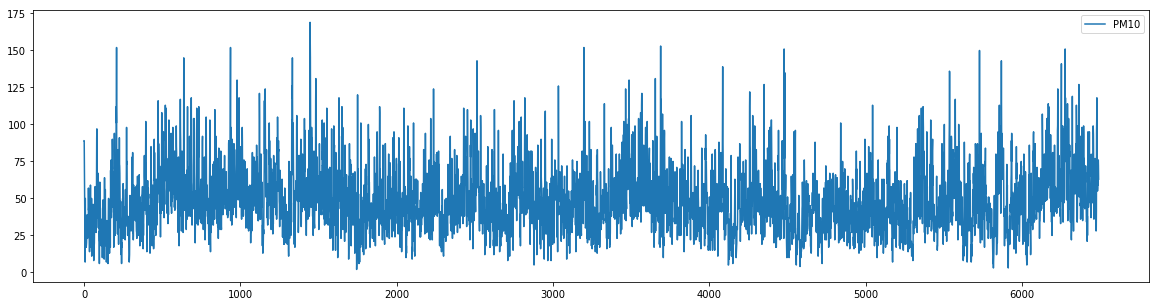

In [6]:
plt.figure(figsize=(20,5))
collocation['PM10'].plot(label='PM10')
plt.legend()
plt.show()

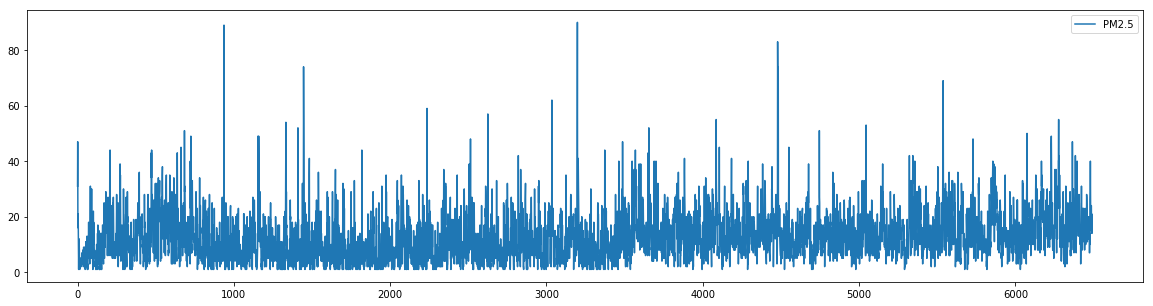

In [7]:
plt.figure(figsize=(20,5))
collocation['PM2,5'].plot(label='PM2.5')
plt.legend()
plt.show()

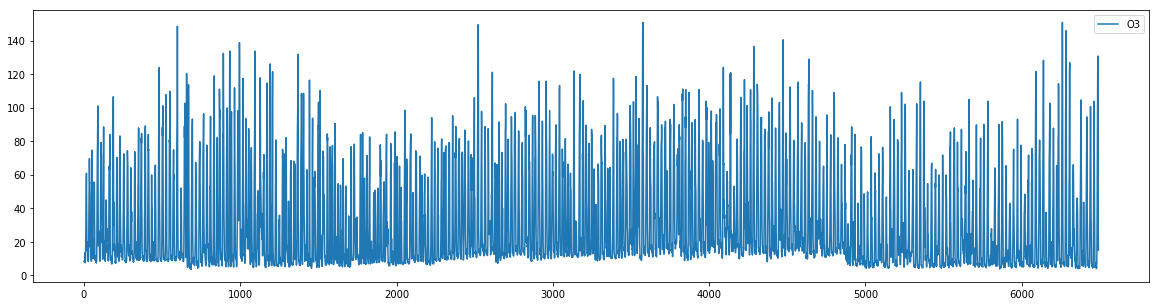

In [8]:
plt.figure(figsize=(20,5))
collocation['O3'].plot(label='O3')
plt.legend()
plt.show()

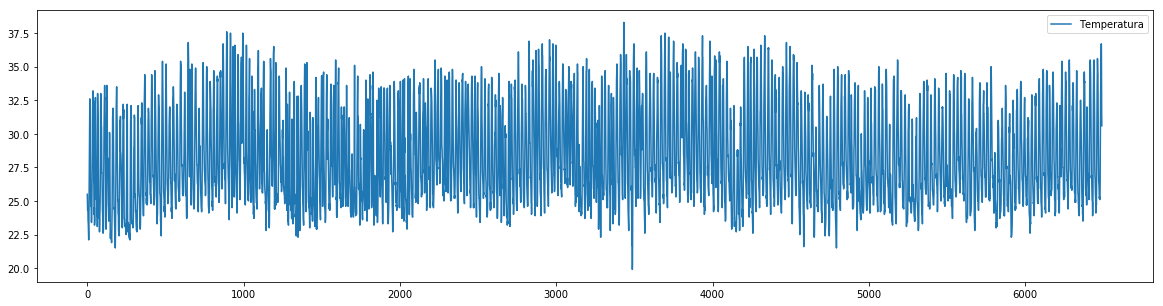

In [9]:
plt.figure(figsize=(20,5))
collocation['Temperatura'].plot(label='Temperatura')
plt.legend()
plt.show()

In [10]:
labels=collocation['PM10']
features=collocation[['VelViento','DirViento','Temperatura','Humedad','Radiacion','Lluvia']]
seed=420

In [11]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = seed)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (4869, 6)
Training Labels Shape: (4869,)
Testing Features Shape: (1623, 6)
Testing Labels Shape: (1623,)


In [12]:
# Saving feature names for later use
feature_list = ['VelViento','DirViento','Temperatura','Humedad','Radiacion','Lluvia']

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = seed)

# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
print('Root Mean Squared Error:', round(np.sqrt(np.mean(errors**2)/len(errors)), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 13.91
Root Mean Squared Error: 0.46
Accuracy: 61.01 %.


In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz

import pydot
# Pull out one tree from the forest
#tree = rf.estimators_[5]
# Export the image to a dot file
#export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('tree.png')
#!dot -Tpdf tree.dot -o tree.pdf
#!convert -density 300 tree.pdf -quality 90 -colorspace RGB tree.png

In [15]:
#from IPython.display import IFrame
#from wand.image import Image as WImage
#from IPython.display import Image
#Image(filename='tree.png') 

In [16]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 4)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
#graph.write_png('small_tree.png');
!dot -Tpdf small_tree.dot -o small_tree.pdf
!convert -density 300 small_tree.pdf -quality 90 -colorspace RGB small_tree.png

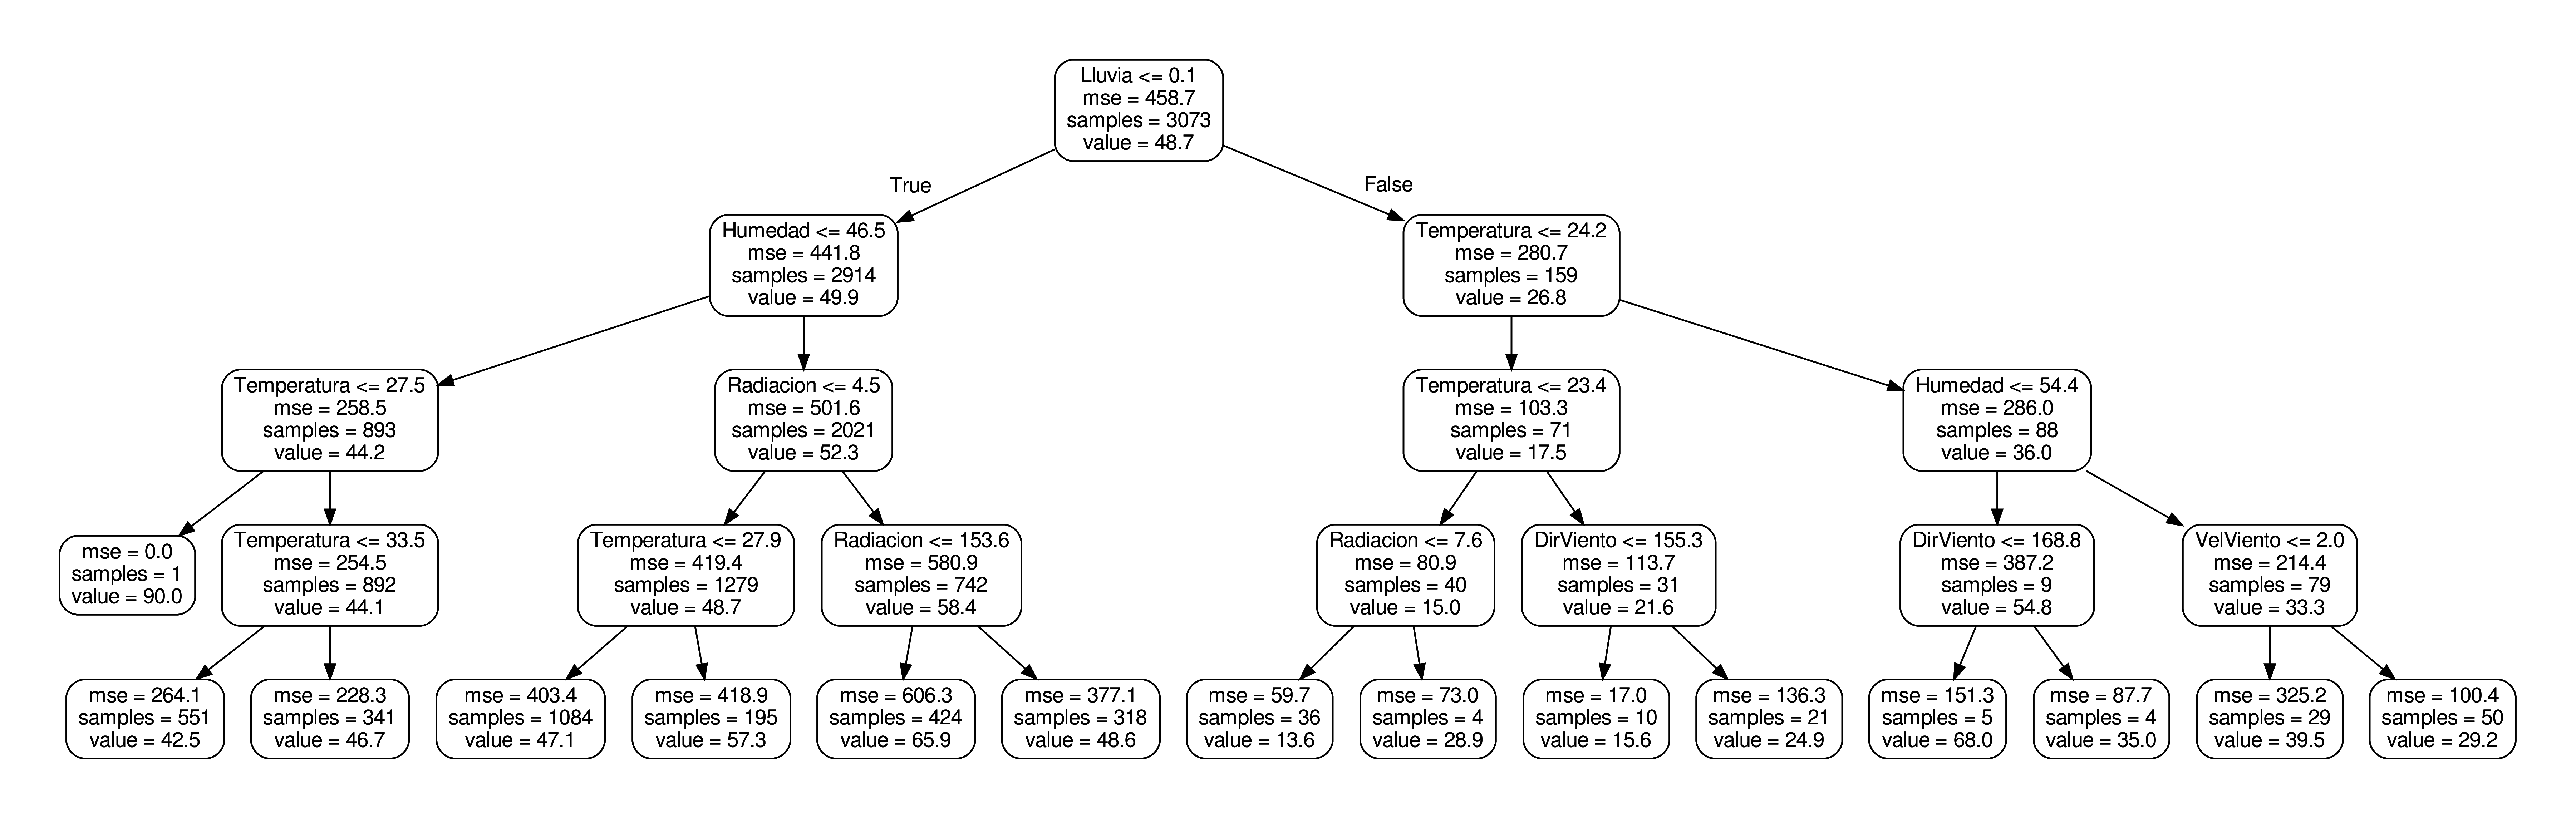

In [17]:
from IPython.display import IFrame
from wand.image import Image as WImage
from IPython.display import Image
Image(filename='small_tree.png') 

In [18]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: DirViento            Importance: 0.23
Variable: Humedad              Importance: 0.22
Variable: Temperatura          Importance: 0.19
Variable: Radiacion            Importance: 0.16
Variable: VelViento            Importance: 0.15
Variable: Lluvia               Importance: 0.05


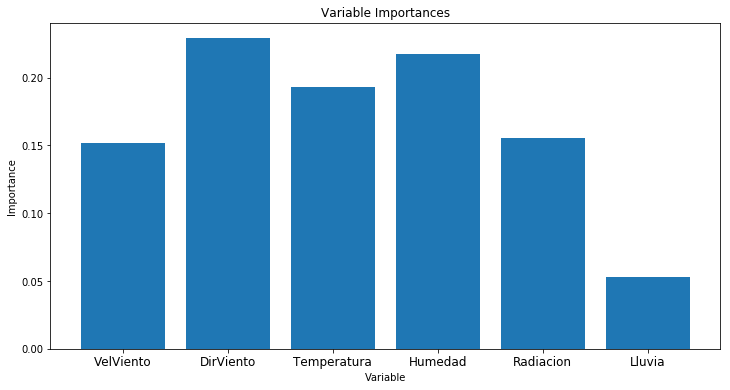

In [19]:
plt.figure(figsize=(12,6))
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='horizontal', fontsize=12)
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Improvement...

In [34]:
def improvement(n_seed,nestimator=1000,testsize=0.25):
    train_features,test_features,train_labels,test_labels=train_test_split(features,labels,test_size=testsize,
                                                                           random_state=n_seed)
    rf = RandomForestRegressor(n_estimators = nestimator, random_state = n_seed)
    # Train the model on training data
    rf.fit(train_features, train_labels);
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors), 2))
    #print('Root Mean Squared Error:', round(np.sqrt(np.mean(errors**2)/len(errors)), 2))
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('seed:',n_seed,'MAE:',round(np.mean(errors),2),'RMSE:',round(np.sqrt(np.mean(errors**2)/len(errors)),2),'Accuracy:',round(accuracy,2),'%.')
    return

In [35]:
seeders=np.arange(10)
seeders

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
for i in seeders:
    print(improvement(i))

seed: 0 MAE: 14.78 RMSE: 0.48 Accuracy: 61.24 %.
None
seed: 1 MAE: 14.48 RMSE: 0.48 Accuracy: 62.48 %.
None
seed: 2 MAE: 14.85 RMSE: 0.49 Accuracy: 59.41 %.
None
seed: 3 MAE: 14.37 RMSE: 0.47 Accuracy: 62.36 %.
None
seed: 4 MAE: 14.66 RMSE: 0.48 Accuracy: 61.26 %.
None
seed: 5 MAE: 14.31 RMSE: 0.47 Accuracy: 60.2 %.
None
seed: 6 MAE: 14.57 RMSE: 0.47 Accuracy: 62.6 %.
None
seed: 7 MAE: 14.17 RMSE: 0.47 Accuracy: 62.32 %.
None
seed: 8 MAE: 14.24 RMSE: 0.47 Accuracy: 62.73 %.
None
seed: 9 MAE: 14.12 RMSE: 0.47 Accuracy: 61.33 %.
None
